# Building a concept map
### Generating a graph of linked concepts
### Recommending learning paths based on student background

First we load extracted concepts from file. 

In [2]:
#filename = 'A Mind For Numbers_ How to Excel at Math and Science (Even If You Flunked Algebra)'
filename = 'CPTSD'
concepts = {}
import pickle
# Loading extracted concepts from file (see concept_extraction.ipynb)
#concepts = {'sents':sents,'rawtxt':rawtxt,'sent_to_npflat':sent_to_npflat,'sent_to_tags':sent_to_tags,'sent_to_ltags':sent_to_ltags,'np_to_sent':np_to_sent,'Conceptdata':Conceptdata}
with open('../processed_data/'+filename +'concepts.pickle', 'rb') as f:
    concepts = pickle.load(f)

# Loading idf dictionary (see Build_IDF_dictionary.ipynb)
with open('../processed_data/idf_dict.pickle','rb') as f1:
    idf_dict =pickle.load(f1)

sents = concepts['sents']
rawtxt = concepts['rawtxt']
sent_to_npflat = concepts['sent_to_npflat']
sent_to_tags= concepts['sent_to_tags']
sent_to_ltags = concepts['sent_to_ltags']
np_to_sent = concepts['np_to_sent']
Conceptdata = concepts['Conceptdata']
inv_eqn_dict = concepts['inv_eqn_dict']

   

Function to get undirected graph between two concepts, weight value is inversely proportional to number of sentences between the two concepts. 

Bond strength = summation of 1/(1+sentence distance) for every time they occur within (max - min) sentence distance

1. max_sent_dist : the maximum sentence between first concept and second concept to consider as linked
2. min_sent_dist : (typically zero) minimum sentence distance between first and second concept to consider as linked
3. sent_to_npflat: dictionary : key: (sentence number in text), value: (list of concepts in the sentence) 


In [3]:
def build_graph(sent_to_npflat,max_sent_dist, min_sent_dist):
    npnp_bondstrengthdir = {}
    for i in range(len(sent_to_npflat)-max_sent_dist):
        for np1 in sent_to_npflat[i]:
            npnp_bondstrengthdir[np1] = {}
            for j in range(min_sent_dist, max_sent_dist):
                np2list = [np2 for np2 in sent_to_npflat[i+j] if np2!=np1]
                for np2 in np2list:
                    npnp_bondstrengthdir[np1][np2] =npnp_bondstrengthdir[np1].get(np2,0) + 1/(j+1)
    return npnp_bondstrengthdir

In [4]:
# Function for term frequency
def tf(np,rawtxt):
   p = re.compile(np)
   return len(p.findall(rawtxt.lower()))        

# Function for IDF
import math
totaldocs = 10788
def get_idf(wrd,totaldocs):
    wrd = wrd.lower()
    return idf_dict.get(wrd,math.log(totaldocs))


In [5]:
# function to find shortest distance (used for graph relationship weight calculations)
import bisect as bs

def find_shortest_distance(search_list, value):
    ins_point = bs.bisect_right(search_list,value)
    if ins_point < len(search_list):
        return min(abs(search_list[ins_point] - value), abs(search_list[ins_point - 1] - value))
    return abs(search_list[ins_point - 1] - value)


In [6]:
npnp_bondstrengthdir = build_graph(sent_to_npflat,2,0)

### Building a data frame with every relationship and metrics about individual concepts and their relationship

Metrics to calculate the importance of the individual concepts, importance of the relationship between them, and directionality.

Directionality: Does knowing ConceptA aid in understanding ConceptB? 

In [7]:
import itertools
from itertools import chain
import numpy as num

lensents = len(sents)
lennp = len(np_to_sent)
Concept1 = [[np1]*len(npnp_bondstrengthdir[np1]) for np1 in npnp_bondstrengthdir.keys()]
Concept1 = list(chain.from_iterable(Concept1))
Concept2 = [np2 for np1 in npnp_bondstrengthdir.keys() for np2 in npnp_bondstrengthdir[np1].keys()]

Bondstrength = [npnp_bondstrengthdir[Concept1[i]][Concept2[i]] for i in range(len(Concept1))]

# Number of sentences in which concept occurs
FA = [len(np_to_sent[np1]) for np1 in Concept1]
FB = [len(np_to_sent[np2]) for np2 in Concept2]

# std deviation of occurence of concept: the spread - does it occur all over the document or just in one section. 
SdevA = [num.std(np_to_sent[np1]) for np1 in Concept1]
SdevB = [num.std(np_to_sent[np2]) for np2 in Concept2]

## Computing the mean bond strength of concept X to other concepts (compared with Bondstrength, gives an idea of how 
## strongly X is related to Y in comparison with other concepts)
meanBSA = [num.mean(list(npnp_bondstrengthdir[np1].values())) for np1 in Concept1]
meanBSB = [num.mean(list(npnp_bondstrengthdir.get(np2,{}).values())) for np2 in Concept2]


## Computing average shortest distance of each A to a B and vice versa. A metric for co-occurence of the two concepts
OcA = [np_to_sent[np1] for np1 in Concept1]
OcB = [np_to_sent[np2] for np2 in Concept2]

dAB=[]
dBA=[]

for i in range(len(Concept1)):
    dAB.append(num.mean([abs(find_shortest_distance(OcB[i],o)) for o in OcA[i]]))
    dBA.append(num.mean([abs(find_shortest_distance(OcA[i],o)) for o in OcB[i]]))
# If dAB is small, then for most occurences of A there is an occurence of B nearby
# IF dBA is small, then for most occurences of B, there is an occurence of A nearby


## Computing number of mappings for Concept1, Concept2 respectively and how many of those concepts intersect
Amap = [len(npnp_bondstrengthdir[np1]) for np1 in Concept1]
Bmap = [len(npnp_bondstrengthdir.get(np2,{})) for np2 in Concept2]
AmapintersectBmap = [len(set(npnp_bondstrengthdir[Concept1[i]].keys()) & set(npnp_bondstrengthdir.get(Concept2[i],{}).keys())) for i in range(len(Concept1))]

## How many concepts is A linked to that B is NOT linked to, and vice versa
AminusB = [Amap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]
BminusA = [Bmap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]




## First occurence of A and B wrt length of text
AfirstOc = [np_to_sent[np1][0]/lensents for np1 in Concept1]
BfirstOc = [np_to_sent[np2][0]/lensents for np2 in Concept2]


## IDF value for each concept (1-gram IDF dictionary. using average for multi word concept phrases)
nptoWtkeys = list(np_to_sent.keys())
nptoWtvals = [np.split() for np in nptoWtkeys]
nptoWt = dict(zip(nptoWtkeys,nptoWtvals))
nptoIDFvals = [num.mean([get_idf(t,totaldocs) for t in nptoWt[np1]]) for np1 in nptoWt.keys()]
nptoIDF = dict(zip(nptoWtkeys,nptoIDFvals))
IDFA = [nptoIDF[np1] for np1 in Concept1]
IDFB = [nptoIDF[np2] for np2 in Concept2]

## Seeing if one concept phrase is present in the other: example: long-term memory, memory. 
AinB = [1 if (len(Concept1[i])>1)and(Concept1[i] in Concept2[i]) else 0 for i in range(len(Concept1))]
BinA = [1 if (len(Concept2[i])>1)and(Concept2[i] in Concept1[i]) else 0 for i in range(len(Concept1))]

C:\Users\Arati\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Arati\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
import pandas as pd
print('making into dataframe')

df = pd.DataFrame({'Concept1':Concept1,'Concept2': Concept2,'FA':FA,'FB':FB,'SdevA':SdevA,'SdevB':SdevB,'Bondstrength':Bondstrength, 'meanBSA':meanBSA, 'meanBSB':meanBSB,'dAB':dAB,'dBA':dBA,'Amap':Amap,'Bmap':Bmap,'AmapintersectBmap':AmapintersectBmap, 'AminusB':AminusB, 'BminusA':BminusA,'AfirstOc':AfirstOc,'BfirstOc':BfirstOc,'IDFA':IDFA,'IDFB':IDFB, 'AinB':AinB, 'BinA':BinA })

making into dataframe


In [9]:
# Looking at some of the concept1-concept2 links. 

print('Total number of relationships in graph', len(df))
df.sort_values(by=['FA','FB','SdevA','SdevB','Amap','Bmap'],ascending=[False]*6).head(20)

Total number of relationships in graph 111818


,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,Bmap,AmapintersectBmap,AminusB,BminusA,AfirstOc,BfirstOc,IDFA,IDFB,AinB,BinA
2144,parent,life,178,85,893.921803,970.437752,0.5,0.583333,0.500000,25.387640,...,12,0,6,12,0.025526,0.001201,4.632229,4.449908,0,0
2142,parent,thought,178,21,893.921803,929.602797,0.5,0.583333,0.833333,57.955056,...,12,0,6,12,0.025526,0.096096,4.632229,4.995730,0,0
2145,parent,picture,178,7,893.921803,989.382058,0.5,0.583333,0.833333,205.140449,...,6,4,2,2,0.025526,0.181982,4.632229,5.675272,0,0
2141,parent,trouble,178,7,893.921803,874.749270,1.0,0.583333,0.583333,197.365169,...,6,5,1,1,0.025526,0.104204,4.632229,5.884992,0,0
2143,parent,more home-made horror movie,178,2,893.921803,707.500000,0.5,0.583333,0.833333,696.325843,...,6,4,2,2,0.025526,0.522823,4.632229,6.923850,0,0
2146,parent,disaster flick,178,2,893.921803,707.500000,0.5,0.583333,0.833333,696.325843,...,6,4,2,2,0.025526,0.522823,4.632229,7.255968,0,0
27544,child,childhood,172,77,865.992542,936.706323,0.5,0.821429,0.857143,22.052326,...,14,1,13,13,0.033934,0.019219,7.340280,8.187577,1,0
27540,child,new york,172,44,865.992542,315.587891,1.5,0.821429,0.722222,560.575581,...,9,0,14,9,0.033934,0.354054,7.340280,2.644005,0,0
27536,child,betrayal,172,7,865.992542,958.921929,1.0,0.821429,0.857143,312.011628,...,14,1,13,13,0.033934,0.133033,7.340280,9.286190,0,0
27542,child,society,172,6,865.992542,1173.130380,1.0,0.821429,0.821429,230.651163,...,14,13,1,1,0.033934,0.000000,7.340280,6.241667,0,0


## Concept importance, Relationship importance and Directionality hypotheses

Before we make the concept graph, we need to ensure the graph is directed and acyclic so it is clear which concept should be learned first, and which topic is more advanced. 

In the absence of annotated concept direction data, (plan to get 'prerequisite' and 'aiding word' information from wikipedia articles), for now, we can look at some hypotheses on directionality, and concept and relationship importance. 

### Concept importance: Is this an important concept in this text?
#### Hypotheses:
1. Higher TF value makes concept more important
2. Higher SdevA,SdevB : concepts are spread out throughout the text
3. Amap: how many concepts ConceptA maps to, the higher the more important the concept.  
4. AfirstOc: how early in the text does A appear
5. Higher Inverse Docuemnt Frequency value makes concept more important

Are all of the above correlated with each other? As in, are we including too many terms? 

In [10]:
# subsetting concept1's metrics and dropping duplicates to avoid recounting
df['TFA'] = df['FA']/lensents
df['TFB'] = df['FB']/lensents
df['TFIDFA'] = df['TFA']*df['IDFA']
df['TFIDFB'] = df['TFB']*df['IDFB']
dfConceptimp = df.copy().loc[:,['Concept1','TFIDFA','FA','SdevA','Amap','AfirstOc','IDFA']].drop_duplicates()

In [11]:
import seaborn as sns
sns.pairplot(dfConceptimp[['TFIDFA','SdevA','Amap','AfirstOc']])
#sns.pairplot(dfConceptimp.sort_values(by='TFIDFA',ascending=False).head(int(0.3*len(dfConceptimp))))

#### Observations
No surprises here:
1. It looks like SdevA and Afirstoc are related: it makes sense that the dispersion of a concept is lower if it is first mentioned later in the text. 
2. Most concepts with high TFIDF are mentioned earlier in the text and have higher spread

Amap does not seem to be strongly correlated with any of the other variables. Maybe the IDF values add some noise? 

In [12]:
#sns.pairplot(dfConceptimp[['FA','Amap','IDFA']])

Amap correlates to raw frequency. We can leave out Amap in this case and just sort by TFIDF

In [13]:
dfConceptimp.sort_values(by=['TFIDFA'],ascending=[False]).head(25)

,Concept1,TFIDFA,FA,SdevA,Amap,AfirstOc,IDFA
355,flashback,0.387622,139,806.154125,17,0.000300,9.286190
27535,child,0.379138,172,865.992542,14,0.033934,7.340280
76,survivor,0.327011,133,906.538361,19,0.000000,8.187577
4171,critic,0.275801,141,668.889401,31,0.026126,6.513601
2141,parent,0.247609,178,893.921803,6,0.025526,4.632229
696,cptsd,0.200782,72,977.133751,5,0.004505,9.286190
1113,feeling,0.194935,104,1013.344868,4,0.009009,6.241667
1573,childhood,0.189322,77,936.706323,14,0.019219,8.187577
29608,shame,0.188376,73,907.225171,9,0.044444,8.593043
21249,fear,0.172479,125,912.501355,8,0.026126,4.594842


This seems to be a reasonable way to order concepts for their importance.

### Relationship importance: 
#### Hypotheses: 

1. The higher the bondstrength, the more important the relationship
2. Bondstrength - max(meanBSA,meanBSB). If bondstrength between A-B is higher than the bondstrength of A with other concepts, and B with other concepts, then the relationship is important. 
3. Low values of min(dAB,dBA) (high co-occurence of A wrt B or B wrt A)
4. High value of AmapintersectBmap (A and B link to a lot of the same concepts)

In [14]:
df['Bondstrengthdiff'] = df['Bondstrength']-(df[['meanBSA','meanBSB']]).max(axis=1)
df['min_dAB_dBA'] = df[['dAB','dBA']].min(axis=1)
dfRelImp = df.copy().loc[:,['Concept1','Concept2','TFIDFA','TFIDFB','min_dAB_dBA','Bondstrengthdiff','AmapintersectBmap']]
#sns.pairplot(dfRelImp,kind="reg")

#### Observations:
1. AmapintersectBmap decreases with increase in min_dAB_dBA, which is expected
2. min_dAB_dBA and low bonstrengthdiff are not as strongly correlated. One measures co-occurence, and the other measures how closely they're linked in comparison to their other relationships. 
Let's look at them sorted by bondstrengthdiff and then co-occurence

In [15]:
dfRelImp[(dfRelImp['TFIDFA']>0.04) & (dfRelImp['TFIDFB']>0.04)].sort_values(by=['Bondstrengthdiff','TFIDFA','TFIDFB'],ascending=[False]*3).head(20)

,Concept1,Concept2,TFIDFA,TFIDFB,min_dAB_dBA,Bondstrengthdiff,AmapintersectBmap
72594,sensation,danger,0.054190,0.078653,63.142857,0.800000,0
573,emotional flashback,critic,0.118703,0.275801,27.434783,0.692308,0
25630,dissociation,fear,0.050196,0.172479,9.444444,0.687500,1
25626,dissociation,sensation,0.050196,0.054190,57.190476,0.687500,1
30525,comfort,child,0.051633,0.379138,8.428571,0.678571,1
4178,critic,anger,0.275801,0.125692,22.484848,0.633333,21
33741,danger,anger,0.078653,0.125692,25.659574,0.633333,21
1656,anger,flashback,0.125692,0.387622,25.075758,0.617647,0
28829,self-compassion,flashback,0.075293,0.387622,27.111111,0.617647,0
38171,psyche,danger,0.066927,0.078653,40.375000,0.590909,1


### Directionality: 
Would knowing Concept A aid in understanding Concept B? 
It is difficult to define this - it could mean that Concept A is a pre-requisite for defining Concept B (temperature -> thermometer), or not, but still play an important role in the explanation. (winter -> thermometer)

After a point, it also depends on the student's background, and feedback would be required. 
Nevertheless, nothing is stopping us from making some rule-based decisions yet. 

#### Hypotheses:
1. Higher AminusB than BminusA, the more concepts A is linked to that B is not linked to, the more likely that A directs to B than vice versa 
2. Difference between dAB and dBA (if B co-occurs with A very often, but A does not, then A more likely directs to B, than vice versa
3. IDFB - IDFA: If the IDF value of A is lower than B, then A more likely directs to B, than vice versa
4. If AinB is 1, then A more likely directs to B than vice versa (Example: ConceptA:'memory', ConceptB 'traumatic memory')

In [16]:
df['AminusB_BminusA_diff'] = df['AminusB'] - df['BminusA']
df['dAB_dBA_diff'] =  df['dAB'] - df['dBA'] 
df['IDFB_IDFA_diff'] = df['IDFB']-df['IDFA']
dfDirectional = df.copy().loc[:,['Concept1','Concept2','TFIDFA','TFIDFB','AminusB_BminusA_diff','dAB_dBA_diff','IDFB_IDFA_diff','AinB']]

Subsetting for high TFIDF concepts, and looking at sections of the dataframe that seem odd
1. high AminusB_BminusA_diff and low dAB_dBA_diff (i.e A is connected to concepts that B is not connected to, yet co-occurs with B much more than B co-occurs with A)
2. IDFB_IDFA_diff is low but A in B is 1

In [17]:
dfDirsub = dfDirectional[(dfDirectional['TFIDFA']>0.024) & (dfDirectional['TFIDFB']>0.024)]
#sns.pairplot(dfDirsub[['AminusB_BminusA_diff','dAB_dBA_diff','IDFB_IDFA_diff','AinB']],kind="reg")

In [18]:
dfDirsub[(dfDirsub['IDFB_IDFA_diff']>0) & (dfDirsub['dAB_dBA_diff']<0)].head(30)

,Concept1,Concept2,TFIDFA,TFIDFB,AminusB_BminusA_diff,dAB_dBA_diff,IDFB_IDFA_diff,AinB
80,survivor,flashback,0.327011,0.387622,2,-0.609942,1.098612,0
485,help,love,0.027087,0.101276,54,-32.444444,4.153661,0
498,help,life,0.027087,0.113586,53,-56.220915,1.109139,0
517,help,friend,0.027087,0.095797,61,-45.814815,3.748196,0
522,help,sense,0.027087,0.066467,0,-29.236467,2.334503,0
532,help,anyone,0.027087,0.051900,54,-18.954416,3.306363,0
535,help,work,0.027087,0.057131,59,-30.970798,0.317799,0
709,article,tao,0.026361,0.039041,6,-107.966667,3.433987,0
775,moment,client,0.025192,0.169768,8,-37.089109,0.354172,0
777,moment,therapy,0.025192,0.089908,3,-23.541667,2.433613,0


### Conclusions and next steps:
Overall, it looks like, in descending order AinB is a strong indicator of direction, as is dAB_dBA_diff. To a lesser extent AminusB_BminusA. 
IDFB_IDFA_dif is weakly correlated with dAB_dBA_diff. 

This should also factor into the weights. 
It would be a good idea to maybe annotate directions manually, (or from wikipedia articles), and do a regression to get direction. 

For now, I am using conditionals, and only a binary value for direction:
    if AinB==1: then direction is 1
    else if AinB==0, then if dAB_dBA_diff > 0, then direction is 1
    else if dAB_dBA_diff==0, then if IDFA_IDFB_diff>0, then direction is 1

#### Assigning directions:

In [19]:
# Assigning directions
df['Direction'] = (df['AinB']==1) | ((df['AinB']==0) & (df['dAB_dBA_diff']>0)) | ((df['AinB']==0) & (df['dAB_dBA_diff']==0) & (df['IDFB_IDFA_diff']<0))
#df['cond'] = num.sum(df[['dAB_dBA_diff','IDFB_IDFA_diff','AminusB_BminusA_diff']],axis=1)
#df['Direction'] = (df['AinB']==1) | (df['cond']>1)
df[df['Direction']==1].sort_values(by='FA',ascending=False).head(5)

,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,TFA,TFB,TFIDFA,TFIDFB,Bondstrengthdiff,min_dAB_dBA,AminusB_BminusA_diff,dAB_dBA_diff,IDFB_IDFA_diff,Direction
2146,parent,disaster flick,178,2,893.921803,707.500000,0.5,0.583333,0.833333,696.325843,...,0.053453,0.000601,0.247609,0.004358,-0.333333,1.500000,0,694.825843,2.623739,True
2141,parent,trouble,178,7,893.921803,874.749270,1.0,0.583333,0.583333,197.365169,...,0.053453,0.002102,0.247609,0.012371,0.416667,4.428571,0,192.936597,1.252763,True
2142,parent,thought,178,21,893.921803,929.602797,0.5,0.583333,0.833333,57.955056,...,0.053453,0.006306,0.247609,0.031505,-0.333333,7.666667,-6,50.288390,0.363501,True
2143,parent,more home-made horror movie,178,2,893.921803,707.500000,0.5,0.583333,0.833333,696.325843,...,0.053453,0.000601,0.247609,0.004158,-0.333333,1.500000,0,694.825843,2.291621,True
2144,parent,life,178,85,893.921803,970.437752,0.5,0.583333,0.500000,25.387640,...,0.053453,0.025526,0.247609,0.113586,-0.083333,18.423529,-6,6.964111,-0.182322,True


### Graph drawing and learning paths:

In [20]:
bond_threshold=num.quantile(df['Bondstrength'],0.2)
print(bond_threshold)
dfdir = df[(df['Direction']>=1) & (df['Bondstrength']>=bond_threshold)]
print(len(dfdir))

import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(dfdir,'Concept1','Concept2', create_using=nx.DiGraph())


0.5
32595


In [21]:
# Getting shortest paths between all pairs
paths=dict(nx.all_pairs_shortest_path(G,cutoff=None))

In [22]:
def get_nodes_allpairs(concept_list):
    nodelist = [paths.get(cl1, {}).get(cl2,None) for cl1 in concept_list for cl2 in concept_list if paths.get(cl1, {}).get(cl2,None) is not None]
    nodelist = list(chain.from_iterable(nodelist))
    return list(set(nodelist))

In [23]:
start_concepts_number = 30   # Start drawing graph with top 20 concepts
dfConceptimp.sort_values(by=['TFIDFA','Amap','SdevA','AfirstOc'],ascending=[False,False,False,True]).head(start_concepts_number)

,Concept1,TFIDFA,FA,SdevA,Amap,AfirstOc,IDFA
355,flashback,0.387622,139,806.154125,17,0.000300,9.286190
27535,child,0.379138,172,865.992542,14,0.033934,7.340280
76,survivor,0.327011,133,906.538361,19,0.000000,8.187577
4171,critic,0.275801,141,668.889401,31,0.026126,6.513601
2141,parent,0.247609,178,893.921803,6,0.025526,4.632229
696,cptsd,0.200782,72,977.133751,5,0.004505,9.286190
1113,feeling,0.194935,104,1013.344868,4,0.009009,6.241667
1573,childhood,0.189322,77,936.706323,14,0.019219,8.187577
29608,shame,0.188376,73,907.225171,9,0.044444,8.593043
21249,fear,0.172479,125,912.501355,8,0.026126,4.594842


Including the following concepts : ['flashback', 'child', 'survivor', 'critic', 'parent', 'cptsd', 'feeling', 'childhood', 'shame', 'fear', 'client', 'therapist', 'tear', 'abandonment', 'anger', 'emotional flashback', 'life', 'image equation4', 'depression', 'recovery', 'love', 'friend', 'inner critic', 'pain', 'therapy', 'mindfulness', 'mother', 'toxic shame', 'outer critic', 'danger']
The nodes that connect these concepts:  ['childhood', 'survivor', 'friend', 'critic', 'flashback', 'great deal', 'child', 'mindfulness', 'parent', 'depression', 'outer critic', 'cptsd', 'fear', 'emotional flashback', 'feeling', 'life', 'pain', 'tear', 'abandonment', 'anyone', 'therapist', 'recovery', 'anger', 'inner critic', 'therapy', 'toxic shame', 'love', 'danger', 'shame', 'image equation4', 'client', 'mother']
{'recovery', 'great deal', 'feeling', 'anger', 'child', 'parent', 'depression', 'childhood', 'life', 'danger', 'survivor', 'client', 'critic', 'anyone'}
{'flashback', 'recovery', 'great deal'

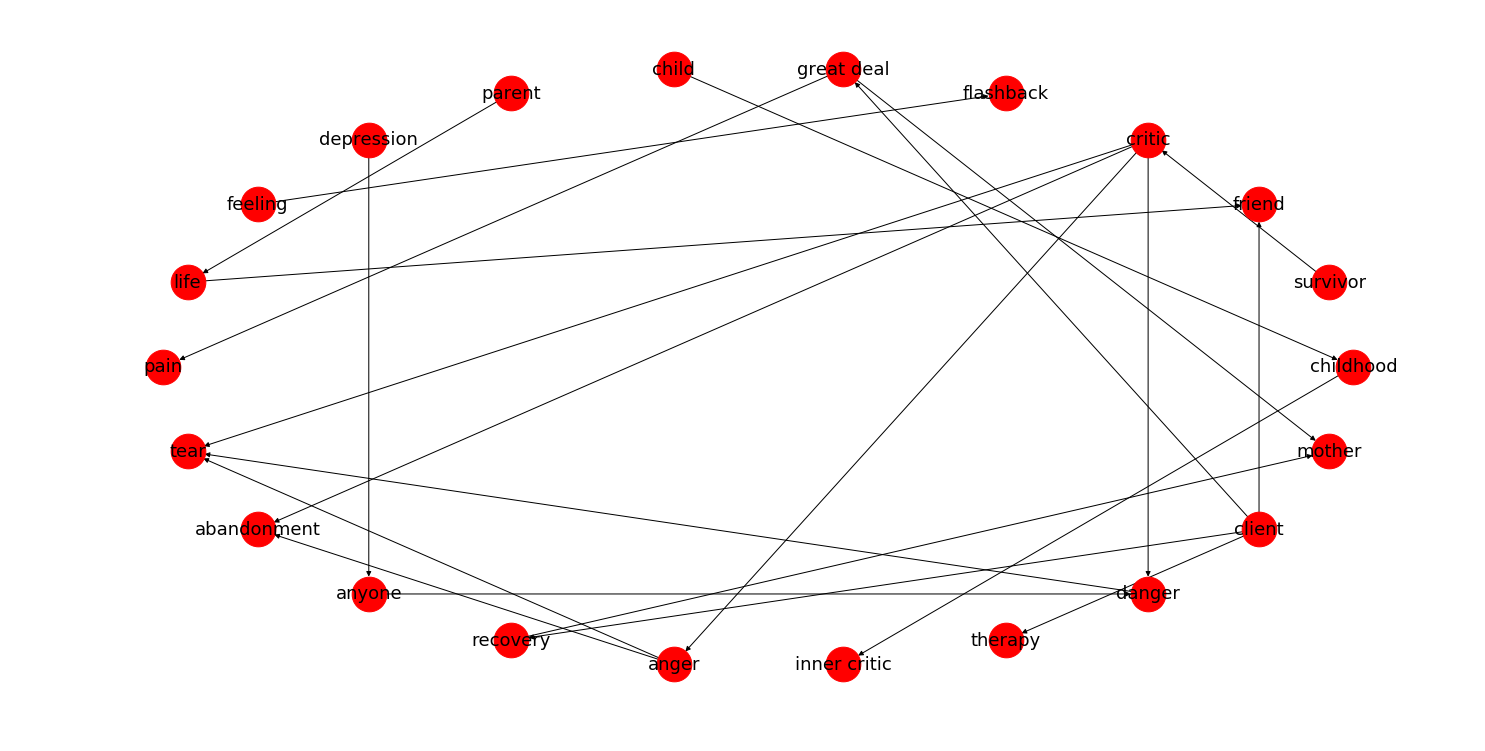

In [24]:
start_concept_list = list(dfConceptimp.sort_values(by=['TFIDFA','Amap','SdevA','AfirstOc'],ascending=[False,False,False,True]).head(start_concepts_number)['Concept1'])

print('Including the following concepts :',start_concept_list)

# now get the paths from all pairs in the concept list and the corresponding nodes 
nodelist = get_nodes_allpairs(start_concept_list)
print('The nodes that connect these concepts: ', nodelist)
start_concept_edges = dfdir[dfdir['Concept1'].isin(nodelist) & dfdir['Concept2'].isin(nodelist)]
start_concept_from = set(start_concept_edges['Concept1'])
print(start_concept_from)
start_concept_to = set(start_concept_edges['Concept2'])
print(start_concept_to)
roots = start_concept_from - start_concept_to
print('Roots: ',roots)

leaves = start_concept_to - start_concept_from
print('Leaves:',leaves)
print('All the longest paths in this subgraph:')
for r in roots:
    for l in leaves:
        if nx.has_path(G,r,l):
            print(paths[r][l])

len(start_concept_edges)
plt.figure(figsize=(20,10))
nx.draw_circular(G.subgraph(list(start_concept_from | start_concept_to)),with_labels=True, font_size=18,node_size=1200)

C:\Users\Arati\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arati\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


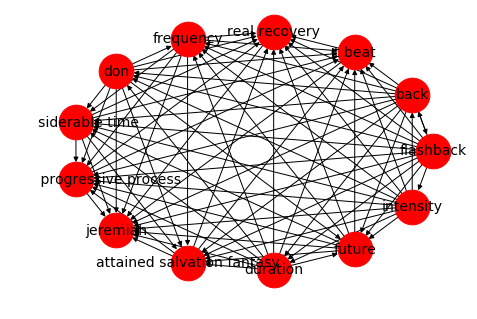

In [25]:
# graph opening with a central concept: order by bond strength and FB
central_concept = 'flashback'
neighbors_frequent = list(dfdir[(df['Concept1']==central_concept) | (df['Concept2']==central_concept)][df['AmapintersectBmap']>num.quantile(df['AmapintersectBmap'],0.74)].sort_values(by = ['FB','Bondstrength'],ascending=[False,False])['Concept2'])
nx.draw_circular(G.subgraph(neighbors_frequent+[central_concept]),with_labels=True, font_size=14,node_size=1200)

In [26]:
with open('../processed_data/'+filename +'conceptmap.pickle', 'wb') as f:
    pickle.dump(df,f)

In [27]:
with open('../processed_data/'+filename + 'conceptimp.pickle','wb') as f1:
    pickle.dump(dfConceptimp,f1)

In [27]:
nptoIDF['flashback']

9.28618968425962

In [23]:
list(nx.simple_cycles(G.subgraph(list(start_concept_from | start_concept_to))))

[]

In [29]:
get_idf('galaxy',10788)

8.18757739559151

In [28]:
list(paths['main sequence']['result'])

KeyError: 'main sequence'

In [29]:
np_to_sent['vector']

[19,
 299,
 551,
 553,
 554,
 555,
 557,
 558,
 559,
 560,
 563,
 564,
 567,
 570,
 574,
 575,
 576,
 577,
 589,
 591,
 595,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 606,
 607,
 609,
 612,
 613,
 614,
 616,
 617,
 851,
 1049,
 1052,
 1057,
 1058,
 1059,
 1061,
 1071,
 1084,
 1299,
 1312,
 1323,
 1344,
 1349,
 1782,
 1956,
 2568,
 2572]

In [30]:
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Concept1,testimonial,testimonial,testimonial,testimonial,testimonial,testimonial,testimonial,testimonial,testimonial,testimonial
Concept2,http,website,image image,survivor,first book,abuse recovering,canada,pete walker,tao,guide and map for recovering from childhood tr...
FA,1,1,1,1,1,1,1,1,1,1
FB,2,12,1,133,9,1,1,1,14,1
SdevA,0,0,0,0,0,0,0,0,0,0
SdevB,422,1210.38,0,906.538,1149.36,0,0,0,1269.71,0
Bondstrength,1,1,1,1,1,1,1,1,1,1
meanBSA,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381
meanBSB,0.75,0.903846,0.952381,0.710526,0.75,0.952381,0.952381,0.952381,0.75,0.952381
dAB,0,0,0,0,0,0,0,0,0,0


C:\Users\Arati\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Arati\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


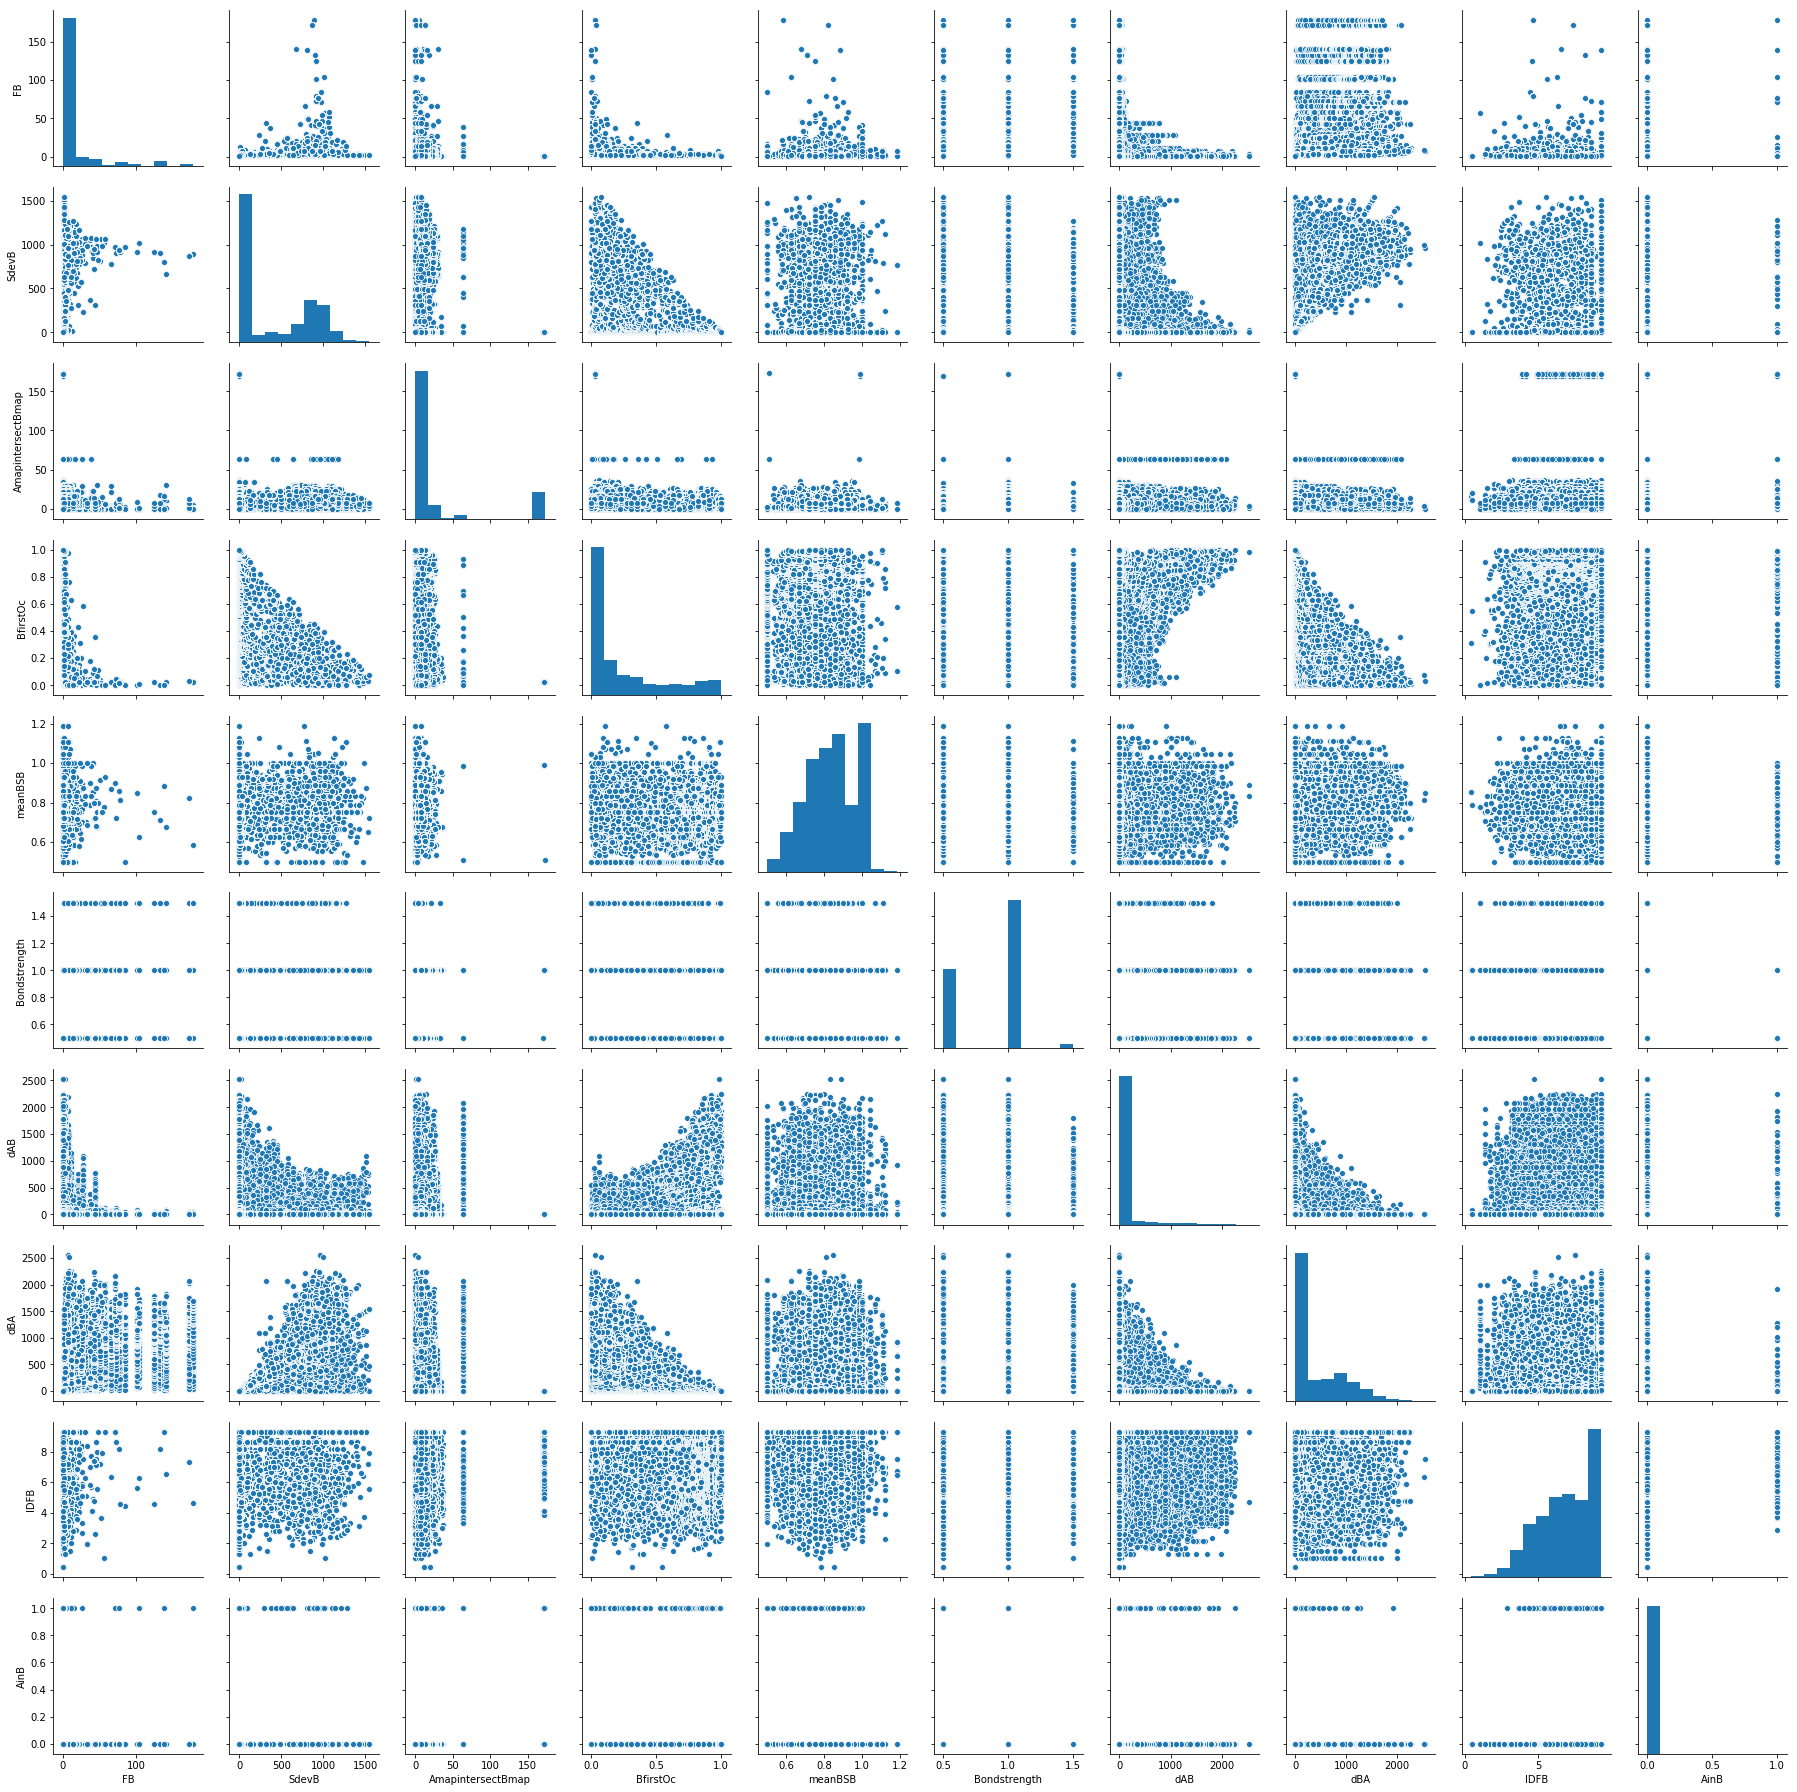

In [53]:
import seaborn as sns
sns.pairplot(df[['FB','SdevB','AmapintersectBmap','BfirstOc','meanBSB','Bondstrength','dAB','dBA','IDFB','AinB']])

In [12]:
df[df['Concept1']=='child'][df['Concept2']=='betrayal']

C:\Users\Arati\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,AfirstOc,BfirstOc,IDFA,IDFB,AinB,BinA,TFA,TFB,TFIDFA,TFIDFB
27536,child,betrayal,172,7,865.992542,958.921929,1.0,0.821429,0.857143,312.011628,...,0.033934,0.133033,7.34028,9.28619,0,0,0.051652,0.002102,0.379138,0.019521


In [15]:
df.sort_values(by=['TFIDFA','dAB'],ascending = [False]*2).head(25)

,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,AfirstOc,BfirstOc,IDFA,IDFB,AinB,BinA,TFA,TFB,TFIDFA,TFIDFB
368,flashback,susan,139,4,806.154125,11.053845,0.5,0.882353,0.583333,1655.352518,...,0.000300,0.975075,9.28619,7.899895,0,0,0.041742,0.001201,0.387622,0.009489
370,flashback,jeremy tarcher,139,1,806.154125,0.000000,0.5,0.882353,0.636364,1655.352518,...,0.000300,0.975075,9.28619,8.736884,0,0,0.041742,0.000300,0.387622,0.002624
371,flashback,los angeles,139,1,806.154125,0.000000,0.5,0.882353,0.636364,1655.352518,...,0.000300,0.975075,9.28619,5.536755,0,0,0.041742,0.000300,0.387622,0.001663
364,flashback,jeremiah,139,1,806.154125,0.000000,1.0,0.882353,0.882353,1654.352518,...,0.000300,0.974775,9.28619,9.286190,0,0,0.041742,0.000300,0.387622,0.002789
366,flashback,ed,139,2,806.154125,34.000000,1.0,0.882353,0.928571,1654.352518,...,0.000300,0.974775,9.28619,7.676752,0,0,0.041742,0.000601,0.387622,0.004611
358,flashback,gradually progressive process,139,2,806.154125,897.500000,1.0,0.882353,0.882353,416.064748,...,0.000300,0.435736,9.28619,5.539028,0,0,0.041742,0.000601,0.387622,0.003327
359,flashback,attained salvation fantasy,139,2,806.154125,897.500000,1.0,0.882353,0.882353,416.064748,...,0.000300,0.435736,9.28619,8.688937,0,0,0.041742,0.000601,0.387622,0.005219
360,flashback,t beat,139,2,806.154125,897.500000,1.0,0.882353,0.882353,416.064748,...,0.000300,0.435736,9.28619,5.381013,0,0,0.041742,0.000601,0.387622,0.003232
367,flashback,real recovery,139,2,806.154125,897.500000,1.0,0.882353,0.882353,416.064748,...,0.000300,0.435736,9.28619,4.157150,0,0,0.041742,0.000601,0.387622,0.002497
355,flashback,considerable time,139,3,806.154125,828.838679,1.0,0.882353,0.882353,406.309353,...,0.000300,0.435736,9.28619,4.061166,0,0,0.041742,0.000901,0.387622,0.003659
